## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Ali Eghbali, Oriyomi Raheem, Michael Pyrcz, Carlos Torres-Verdin
***
## PINN-based Inversion (PyTorch)
***

In [1]:
from main import *

check_torch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
case1, case2, synthetic1, synthetic2 = load_all_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.3.1.post300 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
------------------------------------------------------------

Name              : Source                : Shape
----------------- : --------------------- : -----------
Field Case 1      : (North Africa)        : (2399, 12)
Field Case 2      : (North Sea)           : (11143, 12)
Synthetic Case 1  : (Laminated)           : (801, 14)
Synthetic Case 2  : (Laminated+Dispersed) : (415, 10)


***
### Physics-informed neural network inversion

In [2]:
class PINNLoss(nn.Module):
    def __init__(self, dd_flag:bool=True, ddmax=100, lambda_reg=1e-10, lambda_p=2):
        super(PINNLoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.lambda_p   = lambda_p
        self.dd_flag    = dd_flag
        self.ddmax      = ddmax

    def forward(self, inputs, outputs):
        Rv_true  = inputs[:, 0]
        Rh_true  = inputs[:, 1]
        dd_true  = inputs[:, 2]/self.ddmax
        Rvsh     = inputs[:, 3]
        Rhsh     = inputs[:, 4]
        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]

        eq1 = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred) - (Rv_true)
        eq2 = 1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred) - (Rh_true)
        eqs = torch.stack([eq1, eq2], dim=-1)

        if self.dd_flag:
            wd1, wd2 = 1/Rv_true/dd_true, 1*Rh_true/dd_true
        else:
            wd1, wd2 = 1/Rv_true, 1*Rh_true
        Wdm = torch.stack([wd1, wd2], dim=-1)

        costf = torch.norm(torch.matmul(Wdm.T, eqs), p=2)
        regPa = self.lambda_reg*torch.norm(outputs, p=self.lambda_p)

        return  costf + regPa

In [3]:
class DataLoss(nn.Module):
    def __init__(self, loss_fn=nn.MSELoss(), lambda_p=2):
        super(DataLoss, self).__init__()
        self.dd_loss = loss_fn
        self.lambda_p = lambda_p

    def forward(self, inputs, outputs):
        Rv_true  = inputs[:, 0]
        Rh_true  = inputs[:, 1]
        dd_true  = inputs[:, 2]
        Rvsh     = inputs[:, 3]
        Rhsh     = inputs[:, 4]
        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]
        Rv_sim = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred)
        Rh_sim = 1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)
        v_loss = self.dd_loss(Rv_sim, Rv_true)
        h_loss = self.dd_loss(Rh_sim, Rh_true)
        return torch.norm(torch.stack([v_loss, h_loss], dim=-1), p=self.lambda_p)

In [4]:
class ResInvPINN(nn.Module):
    def __init__(self, hidden_dim:int=128, csh_constraint_mult=1.0):
        super(ResInvPINN, self).__init__()
        self.fc1  = nn.Linear(2, hidden_dim)
        self.fc2  = nn.Linear(hidden_dim, hidden_dim)
        self.fc3  = nn.Linear(hidden_dim, 2)
        self.mult = csh_constraint_mult

    def constraints(self, d):
        c, s = d[:, 0], d[:, 1]
        c = self.mult*torch.sigmoid(c)
        return torch.stack([c, s], dim=-1)
       
    def forward(self, x):
        x = x[:, :2]
        
        x = self.fc1(x)
        x = nn.Tanh()(x)

        x = self.fc2(x)
        x = nn.Tanhshrink()(x)

        x = self.fc3(x)
        x = self.constraints(x)

        return x

***

In [5]:
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh', 'Rvsh', 'Rhsh']

zstart = int(np.argwhere(case1.index==9720).squeeze())
zend   = int(np.argwhere(case1.index==10110).squeeze())
data1  = case1.iloc[zstart:zend]

zstart = int(np.argwhere(case2.index==6292.75).squeeze())
zend   = int(np.argwhere(case2.index==9078.25).squeeze())
data2  = case2.iloc[zstart:zend]

data3 = synthetic1.dropna()
data4 = synthetic2.dropna()

data_all = pd.concat([data1, data2, data3, data4], ignore_index=False)
print('Data_all: {}'.format(data_all.shape))

Data_all: (13896, 18)


In [6]:
dd = 'GR'
res_aniso = data_all[['Rv','Rh', dd, 'Rvsh', 'Rhsh']].dropna()
inputs = torch.tensor(res_aniso.values, dtype=torch.float32).to(device)
print('Inputs: {}'.format(inputs.shape))

Inputs: torch.Size([13896, 5])


In [13]:
inputs.max()

tensor(171.0374, device='cuda:0')

In [7]:
dataset        = TensorDataset(inputs)
train_percent  = 0.8
n_train        = int(train_percent*len(dataset))
xtrain, xvalid = random_split(dataset, [n_train, len(dataset)-n_train])
print('X_train: {} | X_valid: {}'.format(len(xtrain), len(xvalid)))

batch_size  = 32
trainloader = DataLoader(xtrain, batch_size=batch_size, shuffle=True)
validloader = DataLoader(xvalid, batch_size=batch_size, shuffle=True)

X_train: 11116 | X_valid: 2780


In [ ]:
model     = ResInvPINN(hidden_dim=150).to(device)

criterion = PINNLoss(ddmax=data_all[dd].max(), lambda_reg=0, dd_flag=True).to(device)
mseloss   = DataLoss().to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

print('# of Parameters: {:,}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

In [ ]:
epochs, monitor = 301, 100
pinn_lambda = 0.85
train_loss, valid_loss = [], []
for epoch in range(epochs):
    # training
    epoch_train_loss = []
    model.train()
    for i, x in enumerate(trainloader):
        optimizer.zero_grad()
        y = model(x[0])
        loss = (pinn_lambda)*criterion(x[0], y) + (1-pinn_lambda)*mseloss(x[0], y)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        for x in validloader:
            y = model(x[0])
            loss = (pinn_lambda)*criterion(x[0], y) + (1-pinn_lambda)*mseloss(x[0], y)
            epoch_valid_loss.append(loss.item())
        valid_loss.append(np.mean(epoch_valid_loss))
    # progress
    if epoch % monitor == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))

torch.save(model.state_dict(), 'models/model_all.pth')
losses = (train_loss, valid_loss)
plot_loss(losses)

In [ ]:
y_pred = model(inputs[:,:2]).cpu().detach().numpy().squeeze()
Csh_pred, Rss_pred = [y_pred[:, i] for i in range(y_pred.shape[1])]
print('Csh:', ' '*15, 'min: {:.3f}  | max: {:.3f}'.format(Csh_pred.min(), Csh_pred.max()))

Rv_true = res_aniso['Rv'].values
Rh_true = res_aniso['Rh'].values
Rvsh    = res_aniso['Rvsh'].values
Rhsh    = res_aniso['Rhsh'].values

Rv_sim = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred)
Rh_sim = 1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)
Rv_err = np.abs((Rv_sim - Rv_true)/Rv_true) * 100
Rh_err = np.abs((Rh_sim - Rh_true)/Rh_true) * 100

Csh_pred_norm = (Csh_pred - Csh_pred.min())/(Csh_pred.max() - Csh_pred.min())
pinn_sol = pd.DataFrame({'Csh_pred':Csh_pred_norm, 'Rss_pred':Rss_pred, 
                         'Rv_sim':Rv_sim, 'Rh_sim':Rh_sim,
                         'Rv_err':Rv_err, 'Rh_err':Rh_err}, 
                         index=res_aniso.index)

quad_sol = newton_inversion(res_aniso)

results = pd.concat([data_all, pinn_sol, quad_sol], axis=1)
results.to_csv('results/pinn_solution_all.csv', index=True)
error_metrics(results)

***
## Cases

In [5]:
field1_model      = ResInvPINN(hidden_dim=150).to(device)
field1_model.load_state_dict(torch.load('models/model_field1.pth'))
field1_results    = pd.read_csv('results/pinn_solution_field1.csv', index_col=0)
field1_gb_results = pd.read_csv('results/gradient_based_solution_field1.csv', index_col=0)
field1_data       = lasio.read('cases/well1.las').df().loc[field1_results.index]
field1_all        = field1_data.merge(field1_results).set_index(field1_results.index)

field2_model       = ResInvPINN(hidden_dim=150).to(device)
field2_model.load_state_dict(torch.load('models/model_field2.pth'))
field2_results     = pd.read_csv('results/pinn_solution_field2.csv', index_col=0)
field2_gb_results  = pd.read_csv('results/gradient_based_solution_field2.csv', index_col=0)
field2_data        = lasio.read('cases/well2.LAS').df().loc[field2_results.index]
field2_all         = field2_data.merge(field2_results).set_index(field2_results.index)

synth1_model       = ResInvPINN(hidden_dim=150).to(device)
synth1_model.load_state_dict(torch.load('models/model_synthetic1.pth'))
synth1_results     = pd.read_csv('results/pinn_solution_synthetic1.csv', index_col=0)
synth1_gb_results  = pd.read_csv('results/gradient_based_solution_synthetic1.csv', index_col=0).iloc[22:]
synthetic1_data     = lasio.read('cases/Case1.las').df().join(lasio.read('cases/Case1_RvRh.las').df()).loc[synth1_results.index]
synthetic1_all     = synthetic1_data.merge(synth1_results, left_index=True, right_index=True)

synth2_model       = ResInvPINN(hidden_dim=150).to(device)
synth2_model.load_state_dict(torch.load('models/model_synthetic2.pth'))
synth2_results     = pd.read_csv('results/pinn_solution_synthetic2.csv', index_col=0)
synth2_gb_results  = pd.read_csv('results/gradient_based_solution_synthetic2.csv', index_col=0)
synthetic2_data    = lasio.read('cases/Case2.las').df().loc[synth2_results.index]
synthetic2_all     = synthetic2_data.merge(synth2_results).set_index(synth2_results.index)

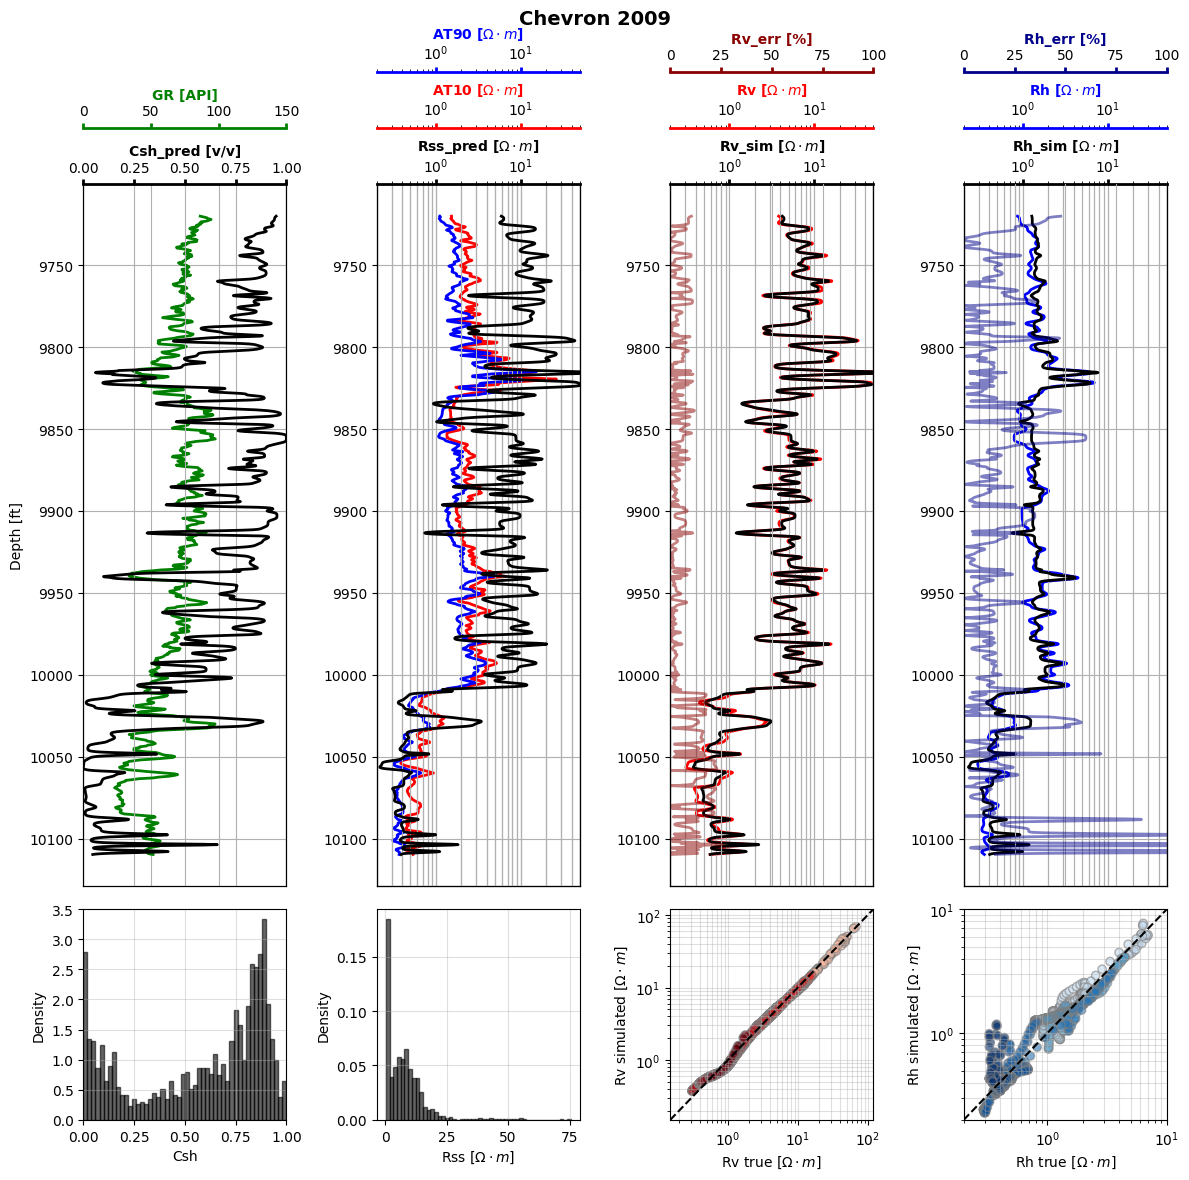

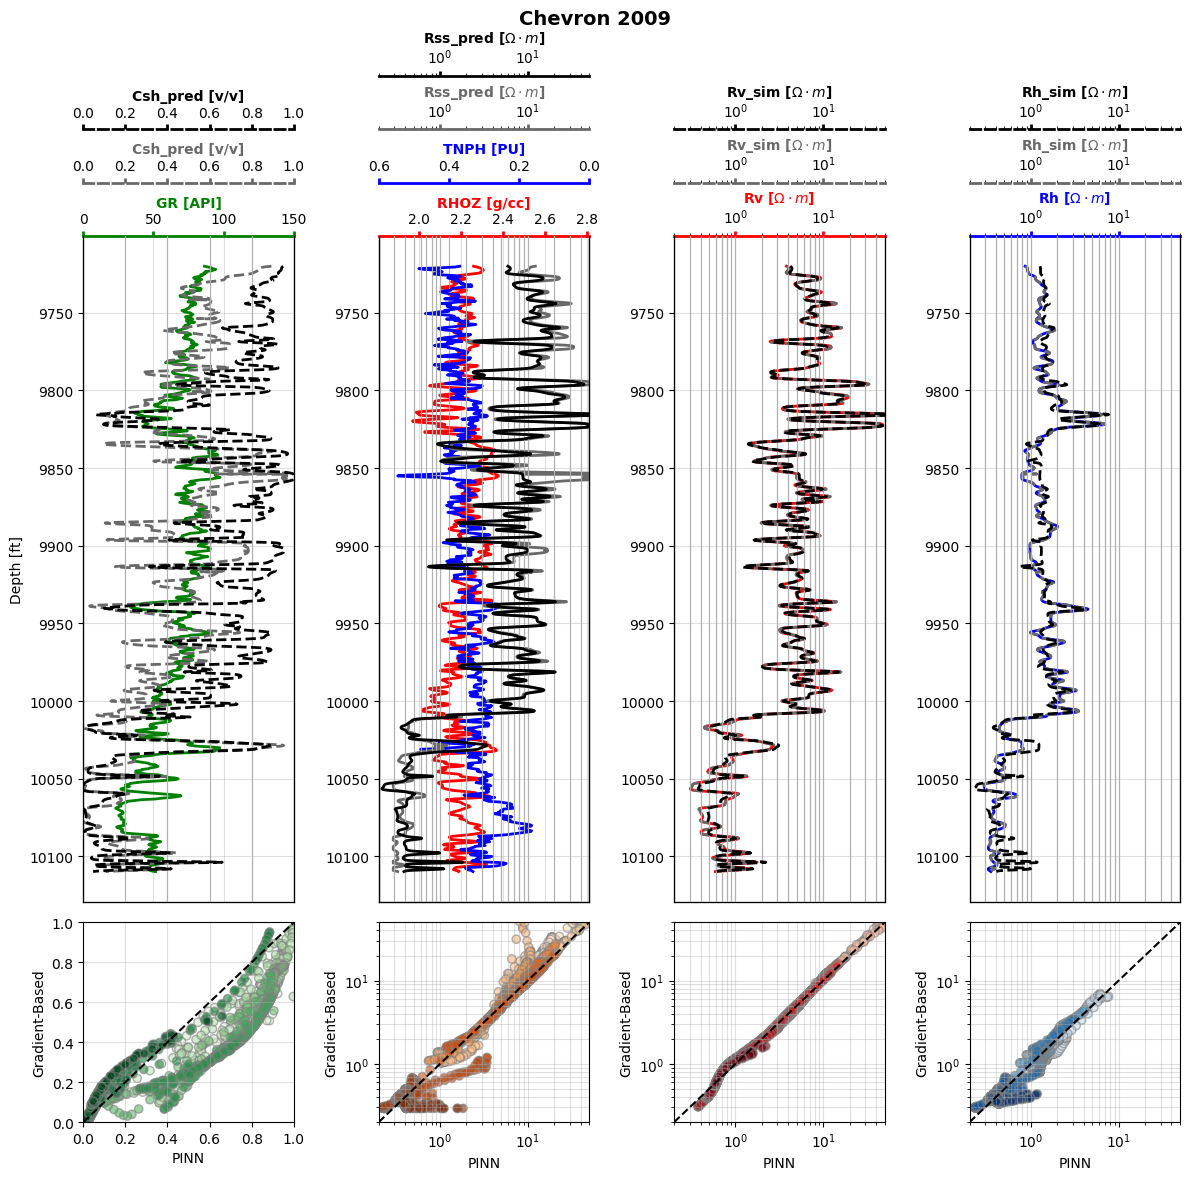

In [6]:
s = 'field1 2009'
plot_pinn_results(field1_results, suptitle=s)
plot_pinn_gb_comparison(field1_all, field1_gb_results, suptitle=s)

In [ ]:
s = 'field2 Hanz Prospect'
plot_pinn_results(field2_results, suptitle=s)
plot_pinn_gb_comparison(field2_all, field2_gb_results, suptitle=s)

In [ ]:
s = 'Synthetic Case 1 (Laminated)'
plot_pinn_results(synth1_results, figsize=(12,12), suptitle=s)
plot_pinn_gb_comparison(synthetic1_all, synth1_gb_results, suptitle=s)

In [ ]:
s = 'Synthetic Case 2 (Laminated + Dispersed)'
plot_pinn_results(synth2_results, suptitle=s, at_flag=False)
plot_pinn_gb_comparison(synthetic2_all, synth2_gb_results, suptitle=s, at_flag=False)

***
# END